# 기본 함수 및 라이브러리 로드

In [1]:
# 경고 제어
import warnings
warnings.filterwarnings('ignore')

# 기본 전처리
import numpy as np
import geopandas as gpd
import pandas as pd
pd.set_option('display.max_columns', 150)
pd.set_option('display.width', 10000)
pd.options.display.float_format = '{:.4f}'.format

# 시각화
import folium
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.rcParams['figure.figsize'] = (12, 9)
from scipy.stats import norm

## 필요 함수 로드

In [2]:
def get_object_type(df):
    """ 
    상권코드의 type을 str로 바꿈
    상권_이름을 삭제
    """
    
    df['상권_코드'] = df['상권_코드'].apply(lambda x: str(x))
    try:
        df.drop('상권_이름', inplace=True, axis=1)
    except:
        pass
    return df

In [3]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
### Scaler들의 함수를 정의함 ###
def get_Standard(df_x):
    s_scaler = StandardScaler()
    return s_scaler.fit_transform(np.array(df_x).reshape(-1, 1))

def get_MinMaxScaler(df_x):
    m_scaler = MinMaxScaler()
    return m_scaler.fit_transform(np.array(df_x).reshape(-1, 1))

def get_Stan_log1p(df_x):
    s_scaler = StandardScaler()
    return s_scaler.fit_transform(np.array(df_x.agg(np.log1p)).reshape(-1, 1))

def get_log1p(df_x):
    return df_x.agg(np.log1p)

In [4]:
from scipy import stats
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

def get_summary(X, y):
    """
    p-value를 체크하는 한다
    """
    X2 = sm.add_constant(X)
    est = sm.OLS(y, X2)
    est2 = est.fit()
    print(est2.summary())

## 검정 함수
### vif 관련 함수

In [5]:
def get_vif(X, least=100, show=False):
    """
    vif를 구하고 이를 데이터 프레임화
    초기 vif 제한수를 100으로 지정
    """
    from statsmodels.stats.outliers_influence import variance_inflation_factor

    vif = pd.DataFrame()
    vif['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['features'] = X.columns
    
    if show:
        print(vif, '\n')
        
    vif = vif[vif['features'] != 'const']
    return vif[vif['VIF Factor'] > least]

### AIC 기반 회귀 함수

In [6]:
def processSubset(X, y, feature_set):
    """
    OLS 기반으로 하여 
    모델, AIC 점수, data, Feature들을 출력한다
    
    후에 getBest 함수에서 루프를 타고서
    AIC 점수들을 비교하여 가장 낮은 점수를 출력하는데 도움을 준다
    """
    feature = list(feature_set)
    model = sm.OLS(y, X[feature])
    regr = model.fit()
    AIC = regr.aic
    data = regr.summary()
    
    return {'model': regr, 'AIC': AIC, 'SUMMARY':data, 'Features':feature}

In [7]:
import itertools

def getBest(X, y, k):
    """ 
    k개의 Feature들의 조합 중 가장 낮은 AIC를 가지는 모델을 선택하고 저장하는 함수
    출력물은 model, k개에 맞는 feature, AIC 점수 
    """
    
    results = []           # 결과 저장 공간
    # 절편 컬럼을 제외한 모든 X컬럼의 경우의 수를 조합
    iters = itertools.combinations(X.columns.difference(['const']), k) 
    
    for combo in iters:
        # 상수항을 추가하여 combo를 결성
        combo = (list(combo)+['const'])
        results.append(processSubset(X, y, feature_set = combo)) # 모델링된 것을 저장
        
        # 만약 k=2이면 여기서 두가지 변수만 뽑아서 경우의 수를 분헉하여
        # 저장 후 그중 AIC가 가장 낮은 모델을 선택하도록 함
        
    models = pd.DataFrame(results)     # 데이터 프레임으로 모델결과 반환
    best_model = models.loc[models['AIC'].argmin()]
    
    return best_model

##### 전진 선택법

In [8]:
def forward(X, y, predictors):
    """
    forward 함수에서는 const를 제외한 모든 feature들을 포함한 AIC 점수를 반환한다.
    predictor는 forward_model에서 정의된 매개변수다.
    forward_model의 predictor에 AIC score를 계산하기 위한 변수들이 저장되며
    그 저장된 변수들을 제외하고서 다시 AIC score를 계산하기 위한 함수
    """
    # predictor - 현재 선택되어 있는 변수
    # 데이터 변수들이 미리 정의된 predictors에 있는지 없는지 확인 및 분류
    
    remaining_predictors = [p for p in X.columns.difference(['const']) if p not in predictors]
    results = []
    for p in remaining_predictors:
        results.append(processSubset(X=X, y=y, feature_set=predictors + [p] + ['const']))
        
    # 데이터 프레임으로 변환
    models = pd.DataFrame(results)
    # AIC가 가장 낮은 것을 선택
    best_model = models.loc[models['AIC'].argmin()]
    
#     print('Processed ', models.shape[0], 'models on', len(predictors)+1)
#     print('Selected predictors:', best_model['model'].model.exog_names, 'AIC: ', best_model[0])
    
    return best_model

def forward_model(X, y):
    """
    전진선택법 모델
    loop를 돌며 forward 함수를 실행시키며 AIC score를 계산하고
    이에 대한 정보를 저장하며 갱신해 나간다.
    loop를 한번 돌때 쓰인 feature들은 predictors에 저장되며 
    이는 forward 함수를 작동할 때 사용되지 않는 용도로 쓰인다.
    """
    Fmodels = pd.DataFrame(columns=['AIC', 'model', 'SUMMARY', 'Features'])
    
    # 미리 정의된 데이터 변수
    # forward에서 AIC를 구할 때 여기에 저장된 변수는 제거하고 계산한다
    predictors = [ ]
    
    for i in range(1, len(X.columns.difference(['const']))+1):
        Forward_result = forward(X, y, predictors)
        if i > 1:
            if Forward_result['AIC'] > Fmodel_before:
                ### AIC 점수가 전의 점수보다 높으면 더이상 loop를 돌지 않고 종료 ###
                break
        Fmodels.loc[i] = Forward_result
        # loop를 돌면서 getBest으로부터(Forward 내부) 계산된 독립변수들이 predictors에 저장됨
        predictors = Fmodels.loc[i]['model'].model.exog_names
        Fmodel_before = Fmodels.loc[i]['AIC']
        ### const를 제외한 변수가 추가된다. ###
        predictors = [ k for k in predictors if k != 'const' ]
    return Fmodels

##### 후진 선택법

In [9]:
def backward(X, y, predictors):
    """
    backward_model을 실행하기 위한 선행 함수
    이 함수에서 back_ward의 predictors에 담긴 feature를 토대로 AIC score를 계산하고 저장한다
    
    for문에서 itertools의 combination을 통해 predictors의 숫자 중 -1의 조합으로 가능한 경우의 수를 구한다.
    예) predictors = 6 일때 6C5 => 6개의 경우의 수 도출
    
    for문을 벗어나면 DataFrame에 저장된 AIC score 중 가장 낮은 레코드를 반환함
    """
    results = []
    
    for combo in itertools.combinations(predictors, len(predictors) - 1):
        results.append(processSubset(X, y, feature_set=list(combo) + ['const']))
    models = pd.DataFrame(results)

    # 가장 낮은 AIC를 가진 모델을 선택
    best_model = models.loc[models['AIC'].argmin()]
    
    return best_model

def backward_model(X, y):
    """
    후진소거법
    backward_model은 'const'를 제외한 모든 feature들을 predictors에 저장하고 시작한다.
    AIC를 저장하는 Bmodel_before 변수의 초기값은 'const'를 제외한 모든 feature들을 고려한 AIC 값을 저장하고
    이후 while문을 거치며 새로운 값으로 갱신함
    
    while 문 안에 있는 predictors에서 변수의 갯수를 최신화 하는데
    이는 backward 함수 안에서 feature의 갯수를 하나씩 줄여나간다.
    그리고 backward 함수에서 len(feature) Combination len(featrue)-1 의 경우의 수로 AIC score를 계산함
    
    while문 종료 조건은 2가지로 나눠진다.
    1. 계산된 AIC가 이전 AIC보다 높을 시
    2. 모든 변수를 사용했을시
    """
    Bmodels = pd.DataFrame(columns= ['AIC', 'model', 'SUMMARY', 'Features'], index=range(1, len(X.columns)))
    predictors = X.columns.difference(['const'])
    Bmodel_before = processSubset(X, y, predictors)['AIC']
    
    idx = 1
    while (len(predictors) > 1):
        Backward_result = backward(X, y, predictors)
        
        # loop를 거치고 계산된 AIC가 이전 AIC보다 높으면 loop 종료
        if Backward_result['AIC'] > Bmodel_before:
            break
        
        Bmodels.loc[idx] = Backward_result
        # model에 쓰인 feature들을 최신화 (이후 backward 함수에서 이 저장된 len(feature) combination len(feature)-1로 계산한다)
        # backward 함수에서 feature의 갯수가 하나 줄어든다.
        predictors = Bmodels.loc[idx]['model'].model.exog_names
        Bmodel_before = Backward_result['AIC']
        predictors = [ k for k in predictors if k != 'const' ]
        idx += 1
        
    return Bmodels.dropna()

##### 단계적 선택법

In [10]:
def Stepwise_model(X, y):
    """
    단계적 선택법
    초기 predictors는 X의 모든 Feature, 
    초기 AIC score는 모든 Feature들이 고려된 score로 시작
    
    후에 loop를 돌며 forward, backward 함수를 실행시켜 두 AIC 점수를 비교한다.
    둘 중 작은 AIC 점수를 저장하고 Feature를 최신화한다.
    """
    Stepmodels = pd.DataFrame(columns = ['AIC', 'model', 'SUMMARY', 'Features'])
    predictors = []
    # 모든 Feature들이 고려된 AIC score
    Stepmodels.loc[0] = getBest(X, y, k=1)
    predictors = Stepmodels.loc[0]['model'].model.exog_names
    predictors = [ k for k in predictors if k != 'const' ]
    Smodel_before = Stepmodels.loc[0]['AIC']

    for i in range(2, len(X.columns.difference(['const'])) + 1):
        
        Forward_result = forward(X, y, predictors)
        Backward_result = backward(X, y, predictors)

        
        if Backward_result['AIC'] < Forward_result['AIC']:
            Stepmodels.loc[i] = Backward_result
            predictors = Stepmodels.loc[i]['model'].model.exog_names
            predictors = [ k for k in predictors if k != 'const' ]
        else:
            Stepmodels.loc[i] = Forward_result
            predictors = Stepmodels.loc[i]['model'].model.exog_names
            predictors = [ k for k in predictors if k != 'const' ]
            
        if Stepmodels.loc[i]['AIC'] > Smodel_before:
            break
        else:
            Smodel_before = Stepmodels.loc[i]['AIC']
            
    return Stepmodels

##### AIC 시각화

In [11]:
def vis_AIC_step(result):
    fig = plt.figure(figsize=(10, 10))
    fig.set_facecolor('white')
    
    font_size = 15
    steps = range(1, result.shape[0]+1)
    AIC = result['AIC'].to_list()
    features = [f'step {i+1}\n' + '\n'.join(s) for i, s in enumerate(result['Features'])]
    
    plt.xticks(steps, features, fontsize=12)
    plt.plot(steps, AIC, marker='o')
    
    plt.ylabel('AIC', fontsize=font_size)
    plt.grid(True)
    plt.show()

### 최적화 함수

In [12]:
def get_best_summary_by_A(model):
    return model.sort_values('AIC').head(1)['SUMMARY'].iloc[0]

def get_best_feature_by_A(model):
    return model.sort_values('AIC').head(1)['Features'].iloc[0]

def get_adj_r_squared_by_A_model(model):
    summary = get_best_summary_by_A(model)
    return float(str(summary).split('Adj. R-squared:')[1].split('Method')[0])

### PCA 함수

In [13]:
from sklearn.decomposition import PCA

def decompo_pca(df, col, new_col):
    
    pca = PCA(n_components=1)
    df[new_col] = pca.fit_transform(pca_df[col])
    df.drop(col, axis=1, inplace=True)
    
    return df

# Data Load

In [14]:
df_i2= pd.read_csv('./data/indicator/preprocess_geo.csv', index_col='상권_코드')
df_i2.head(3)

,공시지가,아파트_단지_수,아파트_가격_2억_미만_세대_수,아파트_가격_2~4억_세대_수,아파트_가격_5억_이상_세대수,아파트_평균_시가,아파트_평균_면적,집객시설_수,관공서_수,은행_수,종합병원_수,일반_병원_수,약국_수,유치원_수,초등학교_수,중학교_수,고등학교_수,대학교_수,슈퍼마켓_수,극장_수,숙박_시설_수,지하철_역_수,버스_정거장_수
상권_코드,,,,,,,,,,,,,,,,,,,,,,,
1000001,4675445.7156,544.0000,2800.0000,582.0000,245.0000,255243240.7500,68.0000,230.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,48.0000,114.0000,0.0000,34.0000
1000002,3689913.5307,179.0000,4372.0000,5775.0000,2984.0000,229979099.5866,49.7500,29.0000,0.0000,4.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.0000,9.0000,0.0000,4.0000
1000003,12411847.7858,32.0000,982.0000,1386.0000,0.0000,177736607.7500,50.0000,152.0000,1.0000,3.0000,0.0000,0.0000,0.0000,4.0000,8.0000,0.0000,0.0000,1.0000,0.0000,3.0000,27.0000,0.0000,16.0000


In [15]:
df_X = df_i2.copy()
df_y = pd.read_csv('./data/base_data/target.csv', index_col='상권_코드')
df_y.head()

,면적당_매출
상권_코드,
1000001,41.1679
1000002,147.5076
1000003,58.5448
1000004,202.0712
1000005,5.4252


# 정규화

In [16]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
cols = df_X.columns
for col in cols:
    df_X[col] = scaler.fit_transform(np.array(df_X[col]).reshape(-1, 1))
    
df_X.describe()

,공시지가,아파트_단지_수,아파트_가격_2억_미만_세대_수,아파트_가격_2~4억_세대_수,아파트_가격_5억_이상_세대수,아파트_평균_시가,아파트_평균_면적,집객시설_수,관공서_수,은행_수,종합병원_수,일반_병원_수,약국_수,유치원_수,초등학교_수,중학교_수,고등학교_수,대학교_수,슈퍼마켓_수,극장_수,숙박_시설_수,지하철_역_수,버스_정거장_수
count,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000
mean,0.1423,0.2073,0.1666,0.2087,0.0869,0.1579,0.3663,0.2014,0.0957,0.0609,0.0081,0.0401,0.1504,0.0823,0.0172,0.0134,0.0052,0.0047,0.0365,0.0051,0.0354,0.0278,0.1688
std,0.1253,0.1543,0.1411,0.1515,0.1346,0.0972,0.0818,0.1263,0.1543,0.1240,0.0722,0.1392,0.1550,0.1829,0.0922,0.1100,0.0549,0.0465,0.1290,0.0408,0.0745,0.1378,0.1613
min,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,0.0725,0.0923,0.0673,0.0982,0.0000,0.1016,0.3228,0.1130,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0612
50%,0.1033,0.1674,0.1240,0.1746,0.0179,0.1260,0.3465,0.1783,0.0000,0.0000,0.0000,0.0000,0.1176,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1429
75%,0.1541,0.2734,0.2289,0.2826,0.1202,0.1791,0.3845,0.2609,0.2222,0.0526,0.0000,0.0000,0.2353,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0526,0.0000,0.2449
max,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


# 1차 분석

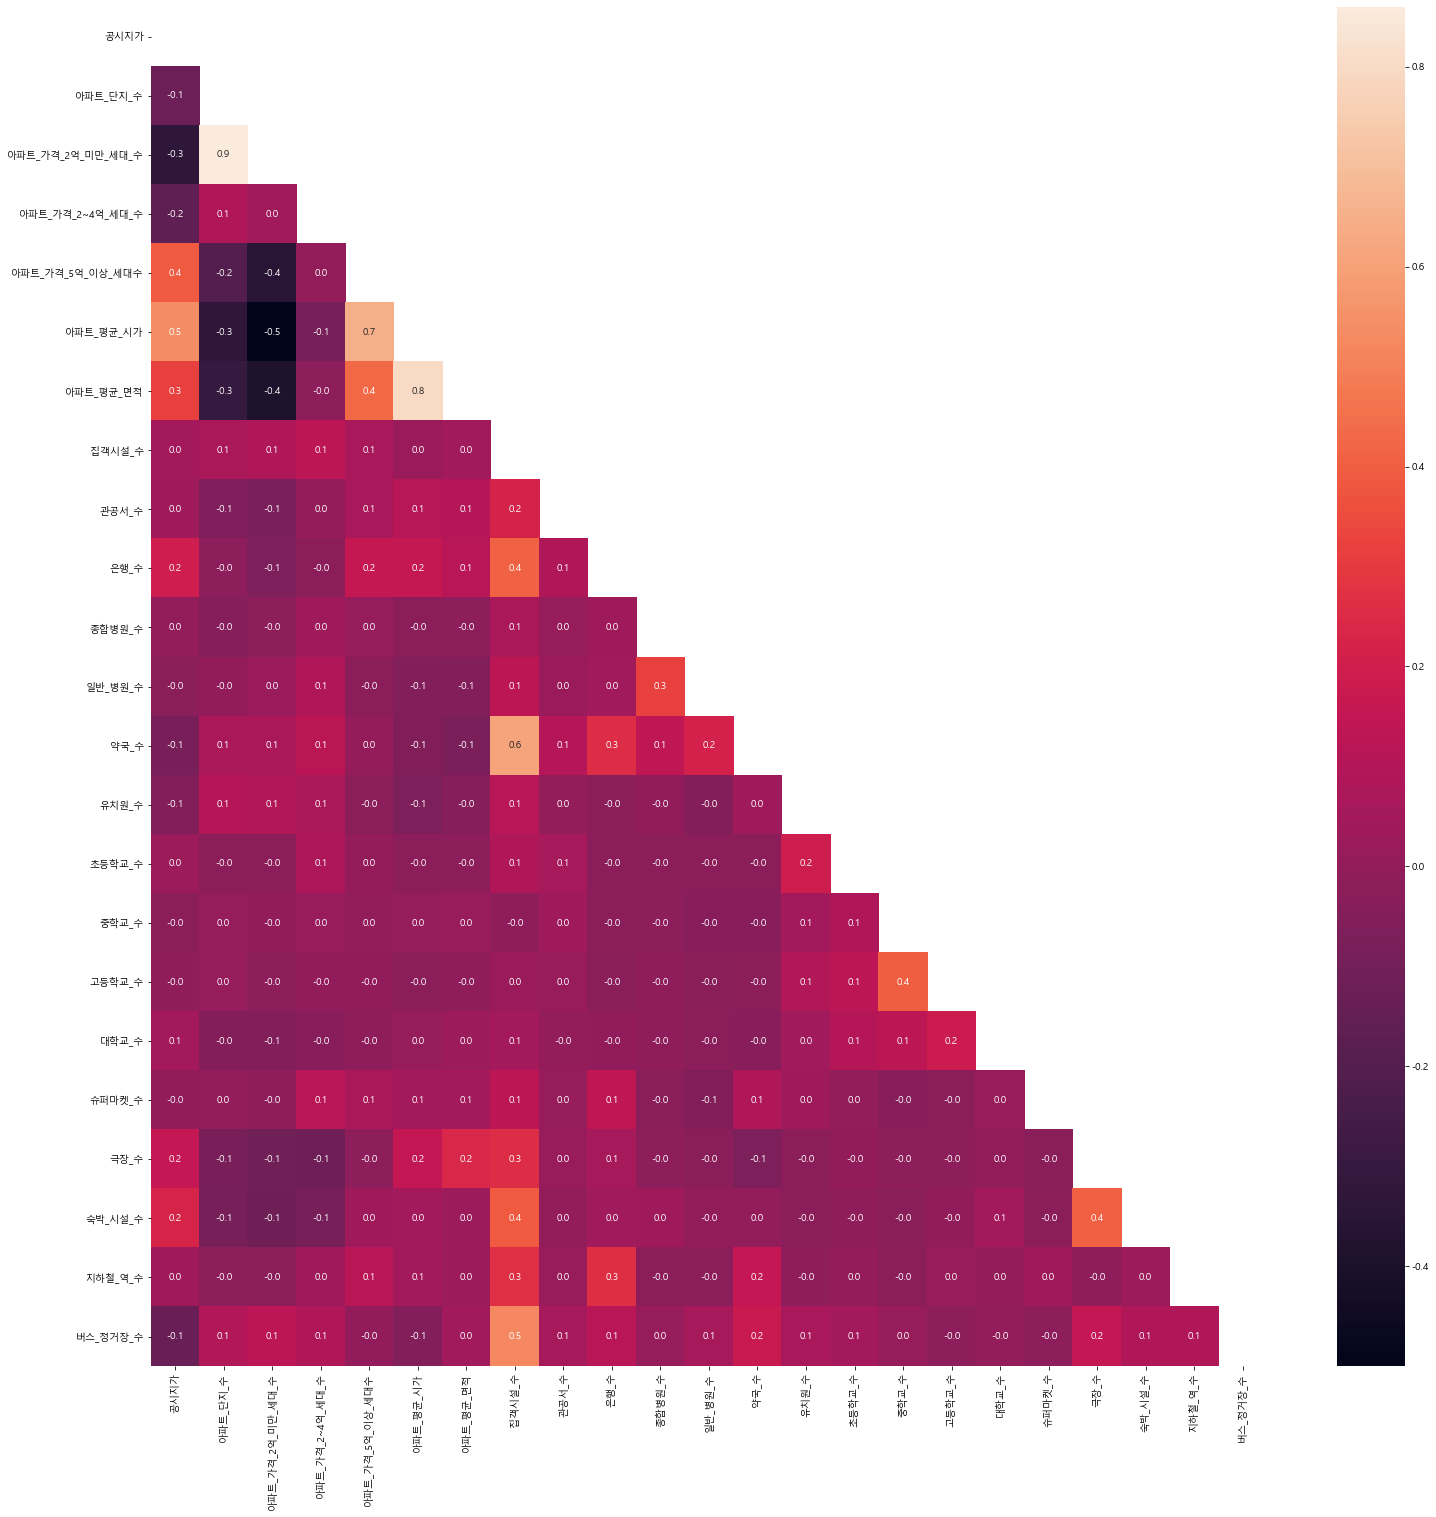

In [17]:
plt.figure(figsize=(25, 25))

mask = np.zeros_like(df_X.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(df_X.corr(), mask=mask, fmt='.1f', annot=True);

In [18]:
model = sm.OLS(df_y, df_X)
regr = model.fit()
data = regr.summary()
data

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 면적당_매출   R-squared (uncentered):                   0.689
Model:                            OLS   Adj. R-squared (uncentered):              0.682
Method:                 Least Squares   F-statistic:                              95.09
Date:                Fri, 17 Dec 2021   Prob (F-statistic):                   2.05e-231
Time:                        16:48:37   Log-Likelihood:                         -5505.9
No. Observations:                1009   AIC:                                  1.106e+04
Df Residuals:                     986   BIC:                                  1.117e+04
Df Model:                          23                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
공시지가                  3.8137     18.819      0.203      0.839     -33.116      40.744
아파트_단지_수            -43.0014     25.346     -1.697      0.090     -92.740       6.737
아파트_가격_2억_미만_세대_수    33.1758     30.287      1.095      0.274     -26.258      92.610
아파트_가격_2~4억_세대_수     -3.7199     12.796     -0.291      0.771     -28.831      21.391
아파트_가격_5억_이상_세대수    -53.9456     18.488     -2.918      0.004     -90.227     -17.664
아파트_평균_시가            95.8236     39.644      2.417      0.016      18.027     173.620
아파트_평균_면적            78.1707     22.418      3.487      0.001      34.178     122.163
집객시설_수              157.3189     31.546      4.987      0.000      95.414     219.224
관공서_수               -23.3431     12.378     -1.886      0.060     -47.634       0.948
은행_수                 53.8180     17.235      3.123      0.002      19.997      87.639
종합병원_수                5.8304     26.547      0.220      0.826     -46.265      57.926
일반_병원_수             -25.7338     14.052     -1.831      0.067     -53.310       1.842
약국_수                 96.2364     17.577      5.475      0.000      61.744     130.728
유치원_수               -18.3294     10.316     -1.777      0.076     -38.574       1.915
초등학교_수              -41.8079     20.521     -2.037      0.042     -82.079      -1.537
중학교_수               -31.3144     18.054     -1.734      0.083     -66.743       4.114
고등학교_수              -13.0810     36.741     -0.356      0.722     -85.181      59.019
대학교_수                37.7112     40.250      0.937      0.349     -41.274     116.697
슈퍼마켓_수                8.8224     14.552      0.606      0.544     -19.734      37.379
극장_수               -274.9905     51.548     -5.335      0.000    -376.147    -173.834
숙박_시설_수             146.0247     32.002      4.563      0.000      83.225     208.825
지하철_역_수               3.8592     14.065      0.274      0.784     -23.741      31.459
버스_정거장_수            -43.6901     14.603     -2.992      0.003     -72.347     -15.034
==============================================================================
Omnibus:                      692.054   Durbin-Watson:                   1.802
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16521.404
Skew:                           2.792   Prob(JB):                         0.00
Kurtosis:                      22.021   Cond. No.                         19.8
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## PCA

In [19]:
pca_df = df_X.copy()
pca_cols = [  ['아파트_평균_면적', '아파트_평균_시가'] ] # 생활인구 관련 Feature 들을 
                                                                                                        # 각각 1차원으로 축소

new_cols = ['면적_시가_pca']  # 새로운 컬럼 이름

for pca_col, new_col in zip(pca_cols, new_cols):
    pca_df = decompo_pca(pca_df, pca_col, new_col)
    
pca_df.head()

,공시지가,아파트_단지_수,아파트_가격_2억_미만_세대_수,아파트_가격_2~4억_세대_수,아파트_가격_5억_이상_세대수,집객시설_수,관공서_수,은행_수,종합병원_수,일반_병원_수,약국_수,유치원_수,초등학교_수,중학교_수,고등학교_수,대학교_수,슈퍼마켓_수,극장_수,숙박_시설_수,지하철_역_수,버스_정거장_수,면적_시가_pca
상권_코드,,,,,,,,,,,,,,,,,,,,,,
1000001,0.1715,0.1234,0.0666,0.0212,0.0092,1.0000,0.0556,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.6939,0.0504
1000002,0.1198,0.0406,0.1040,0.2103,0.1115,0.1261,0.0000,0.2105,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0625,0.0789,0.0000,0.0816,-0.0352
1000003,0.5780,0.0073,0.0234,0.0505,0.0000,0.6609,0.0556,0.1579,0.0000,0.0000,0.0000,0.5000,1.0000,0.0000,0.0000,0.0333,0.0000,0.0625,0.2368,0.0000,0.3265,-0.0615
1000004,0.1548,0.2080,0.1131,0.0736,0.0046,0.1913,0.0000,0.0000,0.0000,0.0000,0.3235,0.0000,0.0000,0.0000,0.0000,0.0000,0.4286,0.0000,0.0263,0.0000,0.4082,-0.0450
1000005,0.0106,0.0955,0.0288,0.0809,0.0376,0.1174,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0625,0.0263,0.0000,0.2449,0.2284


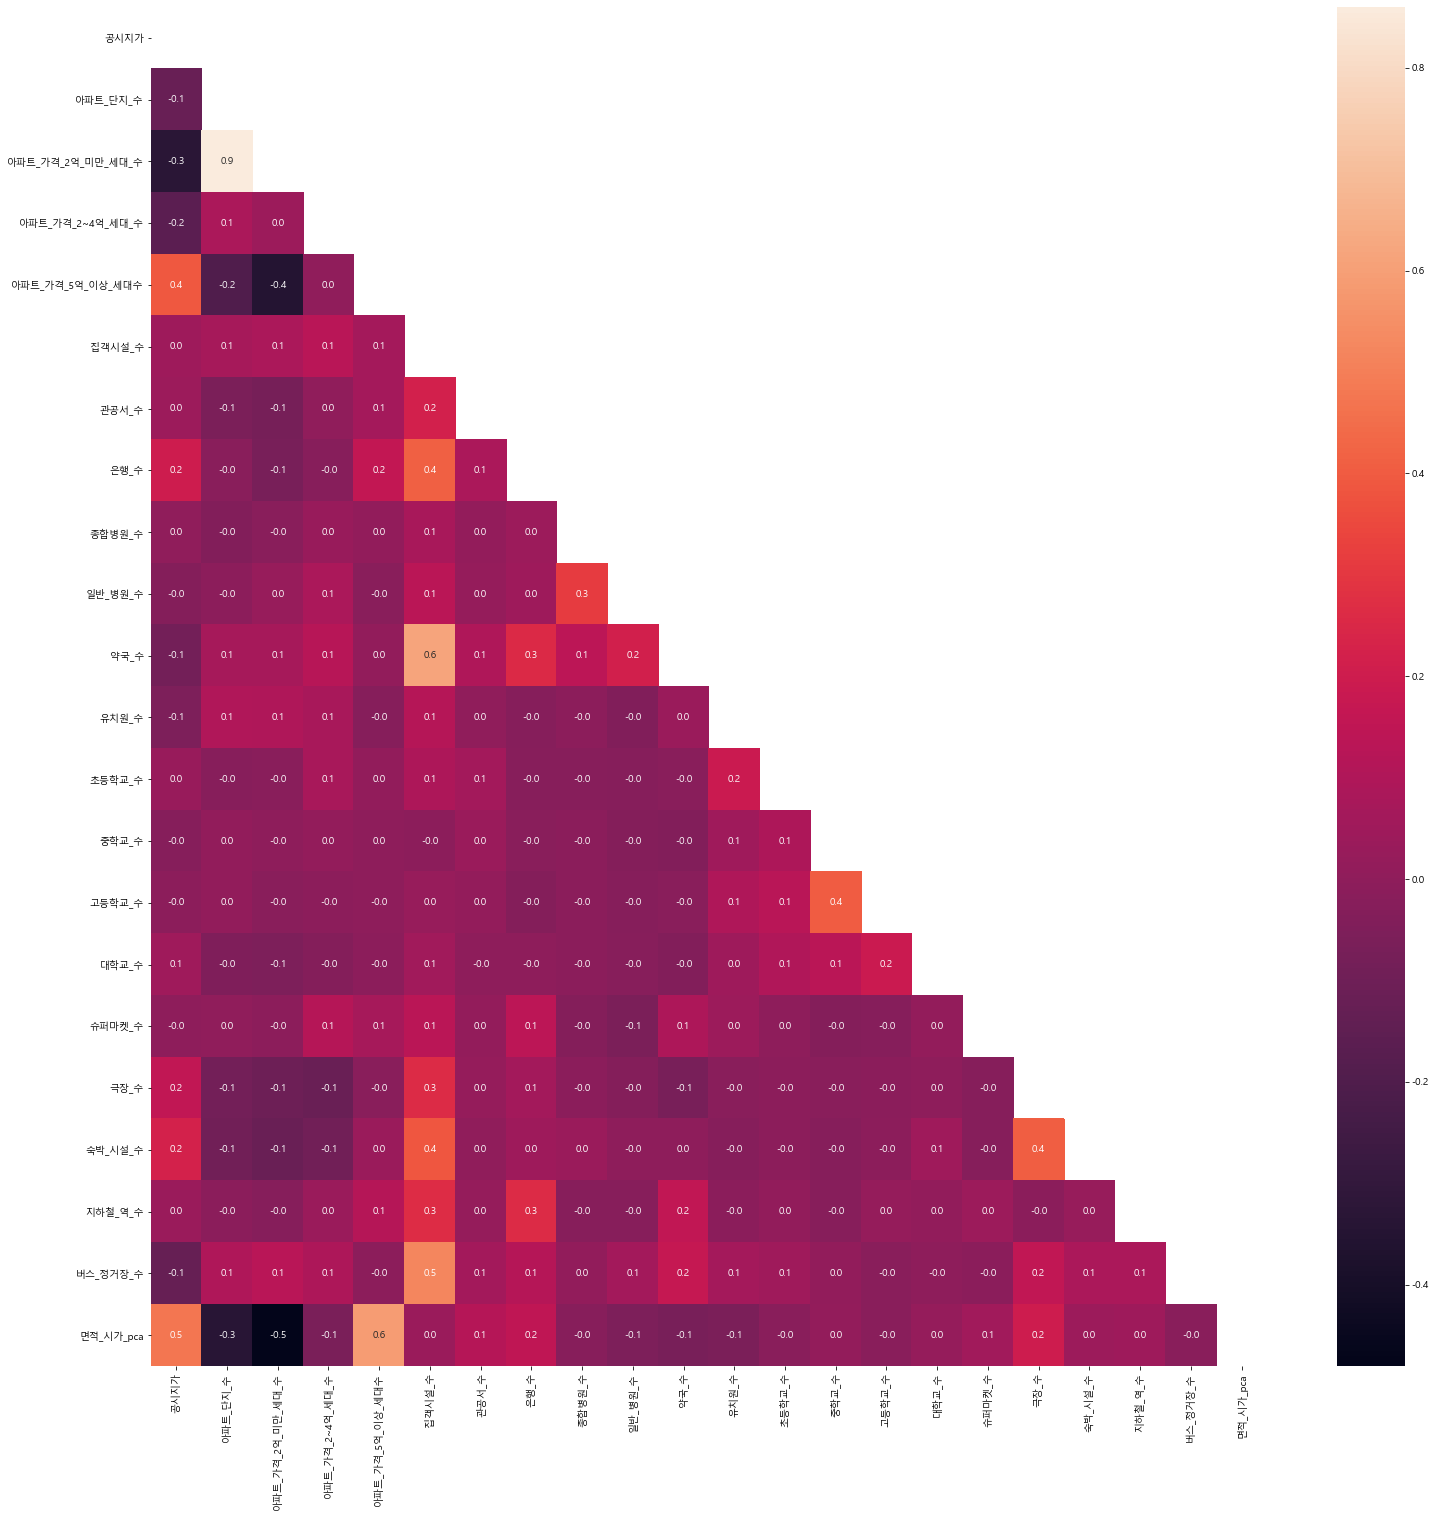

In [20]:
plt.figure(figsize=(25, 25))

mask = np.zeros_like(pca_df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(pca_df.corr(), mask=mask, fmt='.1f', annot=True);

In [21]:
model = sm.OLS(df_y, pca_df)
regr = model.fit()
data = regr.summary()
data

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 면적당_매출   R-squared (uncentered):                   0.663
Model:                            OLS   Adj. R-squared (uncentered):              0.655
Method:                 Least Squares   F-statistic:                              88.26
Date:                Fri, 17 Dec 2021   Prob (F-statistic):                   3.43e-215
Time:                        16:48:40   Log-Likelihood:                         -5546.8
No. Observations:                1009   AIC:                                  1.114e+04
Df Residuals:                     987   BIC:                                  1.125e+04
Df Model:                          22                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
공시지가                 92.8777     16.904      5.494      0.000      59.706     126.049
아파트_단지_수            -55.6990     26.178     -2.128      0.034    -107.069      -4.329
아파트_가격_2억_미만_세대_수    74.3582     30.155      2.466      0.014      15.183     133.533
아파트_가격_2~4억_세대_수     36.1680     11.969      3.022      0.003      12.680      59.656
아파트_가격_5억_이상_세대수      5.8632     17.887      0.328      0.743     -29.238      40.964
집객시설_수              177.8010     32.748      5.429      0.000     113.537     242.065
관공서_수                -5.5627     12.741     -0.437      0.662     -30.565      19.439
은행_수                 48.9478     17.931      2.730      0.006      13.761      84.134
종합병원_수                1.1613     27.615      0.042      0.966     -53.030      55.353
일반_병원_수             -28.2632     14.631     -1.932      0.054     -56.974       0.448
약국_수                103.7096     18.302      5.667      0.000      67.795     139.624
유치원_수               -15.4045     10.726     -1.436      0.151     -36.453       5.644
초등학교_수              -53.5057     21.341     -2.507      0.012     -95.385     -11.626
중학교_수               -23.7945     18.777     -1.267      0.205     -60.642      13.053
고등학교_수              -12.2913     38.227     -0.322      0.748     -87.306      62.724
대학교_수                49.5624     41.834      1.185      0.236     -32.532     131.657
슈퍼마켓_수               11.7490     15.148      0.776      0.438     -17.978      41.476
극장_수               -220.6289     54.498     -4.048      0.000    -327.574    -113.684
숙박_시설_수             128.9536     33.500      3.849      0.000      63.213     194.694
지하철_역_수              -2.8830     14.623     -0.197      0.844     -31.579      25.813
버스_정거장_수            -26.7060     15.007     -1.780      0.075     -56.155       2.742
면적_시가_pca             9.7483     22.404      0.435      0.664     -34.216      53.713
==============================================================================
Omnibus:                      764.310   Durbin-Watson:                   1.792
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            27401.831
Skew:                           3.082   Prob(JB):                         0.00
Kurtosis:                      27.775   Cond. No.                         16.4
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# 점수 지수화

In [22]:
i2_df = pd.DataFrame(columns=['i2_ind1'], index=pca_df.index)

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

lr = LinearRegression()
model = lr.fit(pca_df, df_y)
coef = model.coef_.reshape(-1)

scaler = MinMaxScaler()
coef_df = np.array((pca_df * coef).sum(axis=1))
i2_indi = scaler.fit_transform(coef_df.reshape(-1, 1))
i2_df['i2_ind1'] = i2_indi.reshape(-1)

i2_df.head()

,i2_ind1
상권_코드,
1000001,0.2804
1000002,0.2877
1000003,0.4102
1000004,0.3586
1000005,0.2421


In [24]:
i2_df.to_csv('./data/indicator/indicator_i2.csv')
pd.read_csv('./data/indicator/indicator_i2.csv').head()

,상권_코드,i2_ind1
0,1000001,0.2804
1,1000002,0.2877
2,1000003,0.4102
3,1000004,0.3586
4,1000005,0.2421
